In [1]:
# !pip install transformers
from google.colab import drive
drive.mount('/content/drive')
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


GPU is available


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/labelled_dataset_gpt4o.csv')

In [ ]:
########### using sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device = 0)
# List to store the results
results = []
def truncate_to_max_length(text, max_length):
    encoded_input = tokenizer(text, truncation=True, max_length=max_length, return_tensors='pt')
    return tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)

for index, row in tqdm(df.iterrows(), total=len(df), ncols=100):
    review = row['body']
    label = row['label']

    # Sentence tokenization
    for sentence in sent_tokenize(review):
        truncated_sentence = truncate_to_max_length(sentence, max_length=512)
        # Get sentiment for the sentence
        sentiment_result = sentiment_analyzer(truncated_sentence)[0]

        # Extract sentiment label and score
        sentiment_label = sentiment_result['label']
        sentiment_score = sentiment_result['score']

        # Append results
        results.append({
            # "subreddit": subreddit,
            # "created_utc": created_utc,
            "sentence": sentence,
            "prediction": sentiment_label,
            "sentiment_score": sentiment_score,
            "label": label
        })


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████| 10000/10000 [03:19<00:00, 50.13it/s]


In [ ]:
sentiment_df = pd.DataFrame(results)
sentiment_df.to_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/Distilbert_scoring_dataset.csv',index = False)

In [21]:
# sentiment_df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/Distilbert_scoring_dataset.csv')

In [29]:
threshold = 0.7
sentiment_df.loc[sentiment_df['sentiment_score'] < threshold, 'prediction'] = 'NEUTRAL'

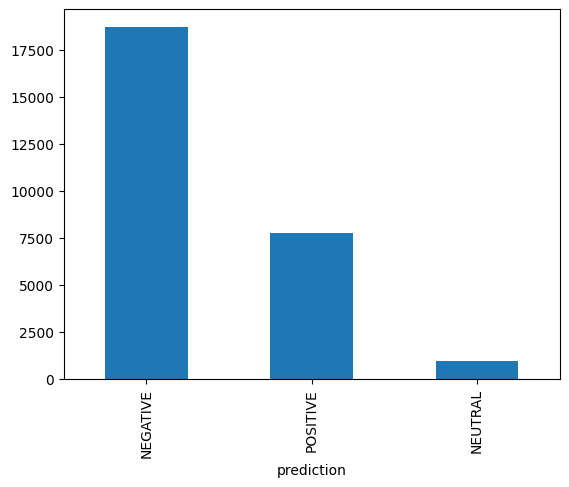

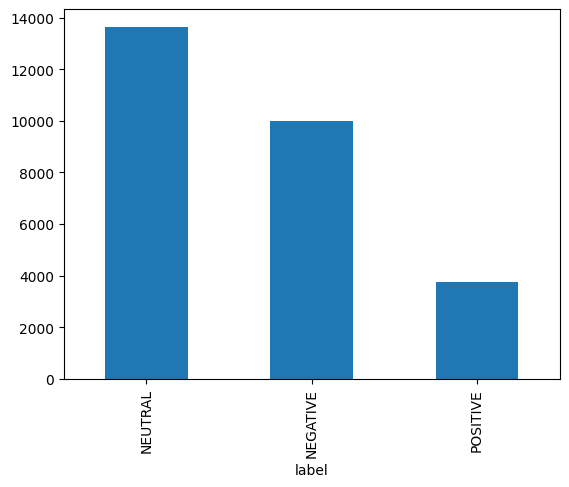

label
NEUTRAL     13649
NEGATIVE    10004
POSITIVE     3766
Name: count, dtype: int64
prediction
NEGATIVE    18743
POSITIVE     7747
NEUTRAL       929
Name: count, dtype: int64


In [30]:
sentiment_df['prediction'].value_counts().plot(kind='bar')
plt.show()
sentiment_df['label'].value_counts().plot(kind='bar')
plt.show()
print(sentiment_df['label'].value_counts())
print(sentiment_df['prediction'].value_counts())

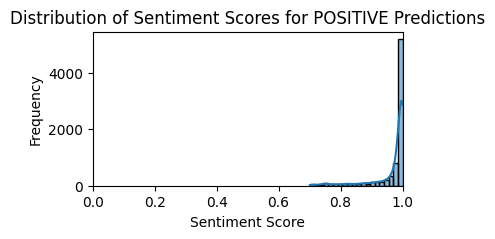

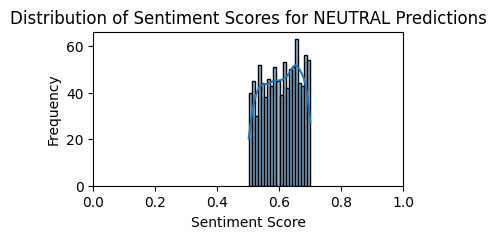

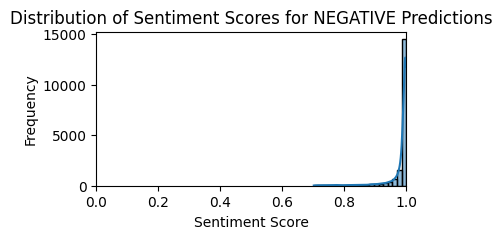

In [31]:
def plot_sentiment_distribution(sentiment_df, sentiment_category):
    # Filter the DataFrame for the specified sentiment category
    filtered_df = sentiment_df[sentiment_df['prediction'] == sentiment_category]

    # Create the histogram for sentiment scores
    plt.figure(figsize=(4, 2))
    sns.histplot(filtered_df['sentiment_score'], bins=20, kde=True)

    # Add labels and title
    plt.title(f'Distribution of Sentiment Scores for {sentiment_category} Predictions')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Assuming sentiment scores range from 0 to 1
    plt.show()

# Plot distributions for each sentiment category
for category in ['POSITIVE', 'NEUTRAL', 'NEGATIVE']:
    plot_sentiment_distribution(sentiment_df, category)

Accuracy: 0.38
Recall: 0.38
F1 Score: 0.28


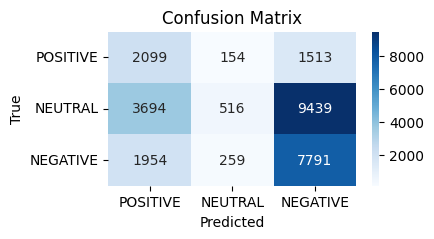

In [32]:
predictions = sentiment_df['prediction']
labels = sentiment_df['label']

cm = confusion_matrix(labels, predictions, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.72
Recall: 0.72
F1 Score: 0.73


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1523: UserWarning: Note that pos_label (set to 'POSITIVE') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1523: UserWarning: Note that pos_label (set to 'POSITIVE') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Accuracy: 0.72
Recall (Positive): 0.72
F1 Score (Positive): 0.73


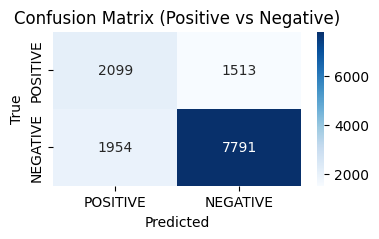

In [35]:
filtered_labels = sentiment_df[sentiment_df['label'].isin(['POSITIVE', 'NEGATIVE'])]
predictions = filtered_labels['prediction']
labels = filtered_labels['label']

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions, labels=['POSITIVE', 'NEGATIVE'])

# Calculate metrics
accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')
# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall (Positive): {recall:.2f}")
print(f"F1 Score (Positive): {f1:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEGATIVE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Positive vs Negative)')
plt.show()